## Выполнение тестового задания для стажировки Разработчик NLP 
Выполнила Бялошицкая Полина

In [682]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from collections import Counter
from tqdm import trange

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim

from wordcloud import WordCloud

from catboost import CatBoostClassifier, Pool
from catboost.utils import get_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

In [683]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/polina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/polina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [684]:
# загрузка всех датасетов
data = pd.read_csv('/Users/polina/Downloads/datasets.csv')
train = pd.read_csv('/Users/polina/Downloads/train.csv')
valid = pd.read_csv('/Users/polina/Downloads/valid.csv')

In [685]:
test = data

In [686]:
data.head()

,Unnamed: 0,text,sentiment
0,43956,Развода на деньги нет\nНаблюдаюсь в Лайфклиник...,1
1,17755,Отель выбрали потому что рядом со стадионом. О...,0
2,20269,"Вылечили\nГноился с рождения глазик, в поликли...",1
3,16648,Хорошее расположение.С вокзала дошли пешком.Но...,0
4,27879,"Отличное месторасположение,прекрасный вид,особ...",1


In [687]:
train.head()

,Unnamed: 0,text,sentiment
0,21098,".с.,и спросил его: о Посланник Аллаха!Ты пори...",1
1,21099,Роднее всех родных Попала я в ГКБ №8 еще в дек...,1
2,21100,Непорядочное отношение к своим работникам Рабо...,2
3,21101,"). Отсутствуют нормативы, Госты и прочее, что ...",1
4,21102,У меня машина в руках 5 лет и это п...,1


In [688]:
valid.head()

,Unnamed: 0,text,sentiment
0,0,Развода на деньги нет Наблюдаюсь в Лайфклиник ...,1
1,1,Отель выбрали потому что рядом со стадионом. О...,0
2,2,"Вылечили Гноился с рождения глазик, в поликлин...",1
3,3,Хорошее расположение.С вокзала дошли пешком.Но...,0
4,4,"Отличное месторасположение,прекрасный вид,особ...",1


# Часть 1. Первичный анализ данных и тематическое моделирование

Пункт 2. Выполнить разведывательный анализ текстовых данных (EDA)

In [689]:
# посмотрим на содержимое данных
data.head(3)

,Unnamed: 0,text,sentiment
0,43956,Развода на деньги нет\nНаблюдаюсь в Лайфклиник...,1
1,17755,Отель выбрали потому что рядом со стадионом. О...,0
2,20269,"Вылечили\nГноился с рождения глазик, в поликли...",1


In [690]:
# посмотрим на тип и количество данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210989 entries, 0 to 210988
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  210989 non-null  int64 
 1   text        210989 non-null  object
 2   sentiment   210989 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [691]:
# посмотрим длину строки каждой строки колонки text 
data['text'].str.len()

0          152
1          720
2          306
3          400
4          473
          ... 
210984     782
210985    1123
210986     401
210987     382
210988     712
Name: text, Length: 210989, dtype: int64

In [692]:
# посмотрим на количество слов каждой строки колонки text
data['text'].str.split().map(lambda x: len(x))

0          22
1         114
2          40
3          49
4          55
         ... 
210984    116
210985    170
210986     84
210987     63
210988     95
Name: text, Length: 210989, dtype: int64

In [693]:
# посмотрим на количество отзывов в соответсвии с их оценкой
data['sentiment'].value_counts()

sentiment
1    100792
2     55310
0     54887
Name: count, dtype: int64

/Users/polina/Library/Python/3.11/lib/python/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/polina/Library/Python/3.11/lib/python/site-packages/seaborn/categorical.py:1273: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/polina/Library/Python/3.11/lib/python/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `n

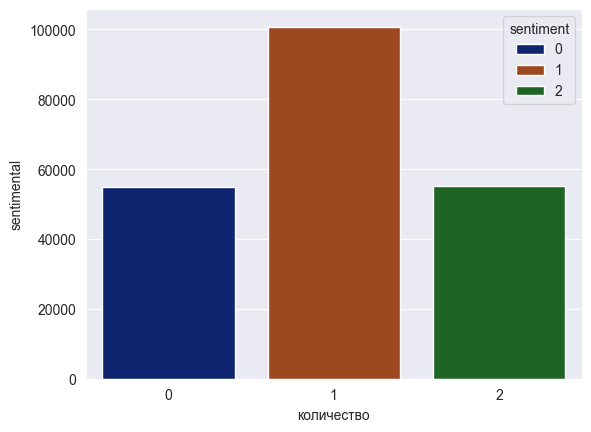

In [694]:
sns.set_style('darkgrid')
sns.countplot(data = data, x = 'sentiment', hue='sentiment', palette='dark')
plt.xlabel('количество')
plt.ylabel('sentimental')
plt.show()

In [695]:
# добавим колонку с количеством символов в строке(длина строки за исключением пробелов)
data['text_len'] = data['text'].apply(lambda x: len(x) - x.count(" "))
data.head(3)

,Unnamed: 0,text,sentiment,text_len
0,43956,Развода на деньги нет\nНаблюдаюсь в Лайфклиник...,1,132
1,17755,Отель выбрали потому что рядом со стадионом. О...,0,607
2,20269,"Вылечили\nГноился с рождения глазик, в поликли...",1,268


In [696]:
# посмотрим среднее количество символов в строке для каждого типа отзывов
mean_0 = np.mean(data[data['sentiment']==0]['text_len'])
mean_1 = np.mean(data[data['sentiment']==1]['text_len'])
mean_2 = np.mean(data[data['sentiment']==2]['text_len'])

In [697]:
print(f'Среднее количество символов для нейтрального отзыва : {mean_0}')
print(f'Среднее количество символов для позитивного отзыва : {mean_1}')
print(f'Среднее количество символов для негативного отзыва : {mean_2}')

Среднее количество символов для нейтрального отзыва : 817.9531765263177
Среднее количество символов для позитивного отзыва : 634.7194618620525
Среднее количество символов для негативного отзыва : 629.6089676369553


In [698]:
# среднее количество символов для нейтрального отзыва больше, чем для позитивного и негативного

In [699]:
# добавим колонку с количеством слов
data['words_count'] = data['text'].str.split().map(lambda x: len(x))
data.head(3)

,Unnamed: 0,text,sentiment,text_len,words_count
0,43956,Развода на деньги нет\nНаблюдаюсь в Лайфклиник...,1,132,22
1,17755,Отель выбрали потому что рядом со стадионом. О...,0,607,114
2,20269,"Вылечили\nГноился с рождения глазик, в поликли...",1,268,40


In [700]:
# посмотрим среднее количество слов для каждого типа отзывов
mean_0_words = np.mean(data[data['sentiment']==0]['words_count'])
mean_1_words = np.mean(data[data['sentiment']==1]['words_count'])
mean_2_words = np.mean(data[data['sentiment']==2]['words_count'])

In [701]:
print(f'Среднее количество слов для нейтрального отзыва : {mean_0_words}')
print(f'Среднее количество слов для позитивного отзыва : {mean_1_words}')
print(f'Среднее количество слов для негативного отзыва : {mean_2_words}')

Среднее количество слов для нейтрального отзыва : 143.13014010603604
Среднее количество слов для позитивного отзыва : 110.5781411223113
Среднее количество слов для негативного отзыва : 117.01280057855722


In [702]:
# среднее количество слов для нейтрального отзыва немного больше, чем для позитивного и негативного

/Users/polina/Library/Python/3.11/lib/python/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.


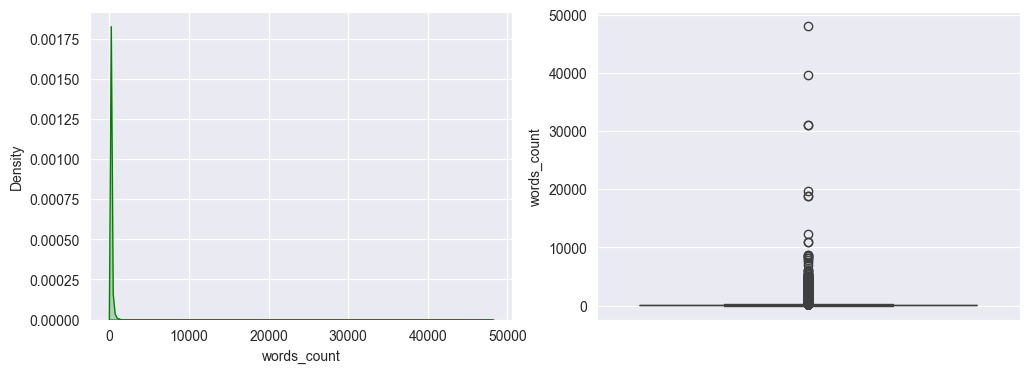

In [703]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.kdeplot(data['words_count'],color='g',fill=True)
plt.subplot(1,2,2)
sns.boxplot(data['words_count'])
plt.show()

По количеству слов есть явно выбросы, что означает, что у нас могут быть неверные гипотезы по соотношению среднего количества слов. Быть может эти выбросы относятся к нейтральным отзывам, а значит, что среднее по ним будет всегда выше, но возможно, если убрать выбросы, то будет другое среднее, или же вообще посчитать медиану, а не среднее. 

# Очистим данные

In [704]:
# заменим "\n" на ". "

In [705]:
def replace_n(text): 
    return re.sub(r'\n', r'. ', text)

In [706]:
data['text_without_n'] = data['text'].apply(lambda x: replace_n(x))
data.head()

,Unnamed: 0,text,sentiment,text_len,words_count,text_without_n
0,43956,Развода на деньги нет\nНаблюдаюсь в Лайфклиник...,1,132,22,Развода на деньги нет. Наблюдаюсь в Лайфклиник...
1,17755,Отель выбрали потому что рядом со стадионом. О...,0,607,114,Отель выбрали потому что рядом со стадионом. О...
2,20269,"Вылечили\nГноился с рождения глазик, в поликли...",1,268,40,"Вылечили. Гноился с рождения глазик, в поликли..."
3,16648,Хорошее расположение.С вокзала дошли пешком.Но...,0,352,49,Хорошее расположение.С вокзала дошли пешком.Но...
4,27879,"Отличное месторасположение,прекрасный вид,особ...",1,419,55,"Отличное месторасположение,прекрасный вид,особ..."


In [707]:
# заменяем пунктуацию на пробел
def replace_punctuation(text):
    return re.sub(r'[.,]+', r' ', text)

In [708]:
data['text_with_space'] = data['text_without_n'].apply(lambda x: replace_punctuation(x))
data.head()

,Unnamed: 0,text,sentiment,text_len,words_count,text_without_n,text_with_space
0,43956,Развода на деньги нет\nНаблюдаюсь в Лайфклиник...,1,132,22,Развода на деньги нет. Наблюдаюсь в Лайфклиник...,Развода на деньги нет Наблюдаюсь в Лайфклиник...
1,17755,Отель выбрали потому что рядом со стадионом. О...,0,607,114,Отель выбрали потому что рядом со стадионом. О...,Отель выбрали потому что рядом со стадионом О...
2,20269,"Вылечили\nГноился с рождения глазик, в поликли...",1,268,40,"Вылечили. Гноился с рождения глазик, в поликли...",Вылечили Гноился с рождения глазик в поликли...
3,16648,Хорошее расположение.С вокзала дошли пешком.Но...,0,352,49,Хорошее расположение.С вокзала дошли пешком.Но...,Хорошее расположение С вокзала дошли пешком Но...
4,27879,"Отличное месторасположение,прекрасный вид,особ...",1,419,55,"Отличное месторасположение,прекрасный вид,особ...",Отличное месторасположение прекрасный вид особ...


In [709]:
# посмотрим на колчичество символов и слов в строках в разрезе оценки 

In [710]:
# добавим колонку с длиной символов за исключением пробелов
data['text_len'] = data['text_with_space'].apply(lambda x: len(x) - x.count(" "))
data.head(3)

,Unnamed: 0,text,sentiment,text_len,words_count,text_without_n,text_with_space
0,43956,Развода на деньги нет\nНаблюдаюсь в Лайфклиник...,1,126,22,Развода на деньги нет. Наблюдаюсь в Лайфклиник...,Развода на деньги нет Наблюдаюсь в Лайфклиник...
1,17755,Отель выбрали потому что рядом со стадионом. О...,0,576,114,Отель выбрали потому что рядом со стадионом. О...,Отель выбрали потому что рядом со стадионом О...
2,20269,"Вылечили\nГноился с рождения глазик, в поликли...",1,258,40,"Вылечили. Гноился с рождения глазик, в поликли...",Вылечили Гноился с рождения глазик в поликли...


In [711]:
# посмотрим среднее количество символов для каждого типа отзывов
mean_0 = np.mean(data[data['sentiment']==0]['text_len'])
mean_1 = np.mean(data[data['sentiment']==1]['text_len'])
mean_2 = np.mean(data[data['sentiment']==2]['text_len'])

In [712]:
print(f'Среднее количество символов для нейтрального отзыва : {mean_0}')
print(f'Среднее количество символов для позитивного отзыва : {mean_1}')
print(f'Среднее количество символов для негативного отзыва : {mean_2}')

Среднее количество символов для нейтрального отзыва : 793.0099112722503
Среднее количество символов для позитивного отзыва : 614.3669537264863
Среднее количество символов для негативного отзыва : 608.3952992225637


In [713]:
# среднее количество символов для нейтрального отзыва больше, чем для позитивного и негативного

In [714]:
# добавим колонку с количеством слов
data['words_count'] = data['text'].str.split().map(lambda x: len(x))
data.head(3)

,Unnamed: 0,text,sentiment,text_len,words_count,text_without_n,text_with_space
0,43956,Развода на деньги нет\nНаблюдаюсь в Лайфклиник...,1,126,22,Развода на деньги нет. Наблюдаюсь в Лайфклиник...,Развода на деньги нет Наблюдаюсь в Лайфклиник...
1,17755,Отель выбрали потому что рядом со стадионом. О...,0,576,114,Отель выбрали потому что рядом со стадионом. О...,Отель выбрали потому что рядом со стадионом О...
2,20269,"Вылечили\nГноился с рождения глазик, в поликли...",1,258,40,"Вылечили. Гноился с рождения глазик, в поликли...",Вылечили Гноился с рождения глазик в поликли...


In [715]:
# посмотрим среднее количество слов для каждого типа отзывов
mean_0_words = np.mean(data[data['sentiment']==0]['words_count'])
mean_1_words = np.mean(data[data['sentiment']==1]['words_count'])
mean_2_words = np.mean(data[data['sentiment']==2]['words_count'])

In [716]:
# среднее количество слов для нейтрального отзыва больше, чем для позитивного и негативного

In [717]:
print(f'Среднее количество слов для нейтрального отзыва : {mean_0_words}')
print(f'Среднее количество слов для позитивного отзыва : {mean_1_words}')
print(f'Среднее количество слов для негативного отзыва : {mean_2_words}')

Среднее количество слов для нейтрального отзыва : 143.13014010603604
Среднее количество слов для позитивного отзыва : 110.5781411223113
Среднее количество слов для негативного отзыва : 117.01280057855722


In [718]:
# создаем токены
def tokenise(text):
    return re.split(r'\W+', text)

In [719]:
data['text_tokenised'] = data['text_with_space'].apply(lambda x: tokenise(x.lower()))
data.head()

,Unnamed: 0,text,sentiment,text_len,words_count,text_without_n,text_with_space,text_tokenised
0,43956,Развода на деньги нет\nНаблюдаюсь в Лайфклиник...,1,126,22,Развода на деньги нет. Наблюдаюсь в Лайфклиник...,Развода на деньги нет Наблюдаюсь в Лайфклиник...,"[развода, на, деньги, нет, наблюдаюсь, в, лайф..."
1,17755,Отель выбрали потому что рядом со стадионом. О...,0,576,114,Отель выбрали потому что рядом со стадионом. О...,Отель выбрали потому что рядом со стадионом О...,"[отель, выбрали, потому, что, рядом, со, стади..."
2,20269,"Вылечили\nГноился с рождения глазик, в поликли...",1,258,40,"Вылечили. Гноился с рождения глазик, в поликли...",Вылечили Гноился с рождения глазик в поликли...,"[вылечили, гноился, с, рождения, глазик, в, по..."
3,16648,Хорошее расположение.С вокзала дошли пешком.Но...,0,335,49,Хорошее расположение.С вокзала дошли пешком.Но...,Хорошее расположение С вокзала дошли пешком Но...,"[хорошее, расположение, с, вокзала, дошли, пеш..."
4,27879,"Отличное месторасположение,прекрасный вид,особ...",1,405,55,"Отличное месторасположение,прекрасный вид,особ...",Отличное месторасположение прекрасный вид особ...,"[отличное, месторасположение, прекрасный, вид,..."


In [720]:
# убираем стоп слова

In [721]:
stopword = nltk.corpus.stopwords.words('russian')

In [722]:
def remove_stopwords(tokenised_list):
    return [word for word in tokenised_list if word not in stopword]

In [723]:
data['text_nostop'] = data['text_tokenised'].apply(lambda x: remove_stopwords(x))
data.head()

,Unnamed: 0,text,sentiment,text_len,words_count,text_without_n,text_with_space,text_tokenised,text_nostop
0,43956,Развода на деньги нет\nНаблюдаюсь в Лайфклиник...,1,126,22,Развода на деньги нет. Наблюдаюсь в Лайфклиник...,Развода на деньги нет Наблюдаюсь в Лайфклиник...,"[развода, на, деньги, нет, наблюдаюсь, в, лайф...","[развода, деньги, наблюдаюсь, лайфклиник, бере..."
1,17755,Отель выбрали потому что рядом со стадионом. О...,0,576,114,Отель выбрали потому что рядом со стадионом. О...,Отель выбрали потому что рядом со стадионом О...,"[отель, выбрали, потому, что, рядом, со, стади...","[отель, выбрали, рядом, стадионом, отель, 4, н..."
2,20269,"Вылечили\nГноился с рождения глазик, в поликли...",1,258,40,"Вылечили. Гноился с рождения глазик, в поликли...",Вылечили Гноился с рождения глазик в поликли...,"[вылечили, гноился, с, рождения, глазик, в, по...","[вылечили, гноился, рождения, глазик, поликлин..."
3,16648,Хорошее расположение.С вокзала дошли пешком.Но...,0,335,49,Хорошее расположение.С вокзала дошли пешком.Но...,Хорошее расположение С вокзала дошли пешком Но...,"[хорошее, расположение, с, вокзала, дошли, пеш...","[хорошее, расположение, вокзала, дошли, пешком..."
4,27879,"Отличное месторасположение,прекрасный вид,особ...",1,405,55,"Отличное месторасположение,прекрасный вид,особ...",Отличное месторасположение прекрасный вид особ...,"[отличное, месторасположение, прекрасный, вид,...","[отличное, месторасположение, прекрасный, вид,..."


In [724]:
# применим стемминг к строкам

In [725]:
stemmer = SnowballStemmer("russian")

In [726]:
def stemming(tokenised_text):
    return [stemmer.stem(word) for word in tokenised_text]

In [727]:
data['text_stemmed'] = data['text_nostop'].apply(lambda x: stemming(x))
data.head(3)

,Unnamed: 0,text,sentiment,text_len,words_count,text_without_n,text_with_space,text_tokenised,text_nostop,text_stemmed
0,43956,Развода на деньги нет\nНаблюдаюсь в Лайфклиник...,1,126,22,Развода на деньги нет. Наблюдаюсь в Лайфклиник...,Развода на деньги нет Наблюдаюсь в Лайфклиник...,"[развода, на, деньги, нет, наблюдаюсь, в, лайф...","[развода, деньги, наблюдаюсь, лайфклиник, бере...","[развод, деньг, наблюда, лайфклиник, беремен, ..."
1,17755,Отель выбрали потому что рядом со стадионом. О...,0,576,114,Отель выбрали потому что рядом со стадионом. О...,Отель выбрали потому что рядом со стадионом О...,"[отель, выбрали, потому, что, рядом, со, стади...","[отель, выбрали, рядом, стадионом, отель, 4, н...","[отел, выбра, ряд, стадион, отел, 4, номер, бо..."
2,20269,"Вылечили\nГноился с рождения глазик, в поликли...",1,258,40,"Вылечили. Гноился с рождения глазик, в поликли...",Вылечили Гноился с рождения глазик в поликли...,"[вылечили, гноился, с, рождения, глазик, в, по...","[вылечили, гноился, рождения, глазик, поликлин...","[вылеч, гно, рожден, глазик, поликлиник, назна..."


In [728]:
corpus = []
for row in data['text_stemmed'].values:
    corpus += row
len(corpus)

16985471

In [729]:
corpus[:20]

['развод',
 'деньг',
 'наблюда',
 'лайфклиник',
 'беремен',
 'развод',
 'деньг',
 'врач',
 'плох',
 'повод',
 'ресепш',
 'соглаш',
 'пута',
 'документ',
 '',
 'отел',
 'выбра',
 'ряд',
 'стадион',
 'отел']

In [730]:
mostCommon = Counter(corpus).most_common(20)
mostCommon

[('', 203989),
 ('эт', 171175),
 ('очен', 159343),
 ('отел', 117376),
 ('номер', 91072),
 ('врач', 89806),
 ('котор', 87300),
 ('год', 76005),
 ('так', 66721),
 ('сам', 62138),
 ('сво', 59313),
 ('хорош', 57151),
 ('спасиб', 51700),
 ('прост', 50415),
 ('больш', 45888),
 ('2', 43644),
 ('сказа', 43555),
 ('наш', 42730),
 ('мест', 39993),
 ('завтрак', 39874)]

In [731]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

/Users/polina/Library/Python/3.11/lib/python/site-packages/seaborn/categorical.py:1273: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


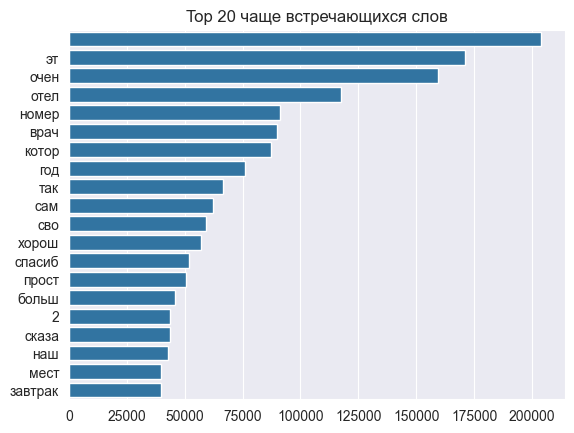

In [732]:
sns.barplot(x=freq, y=words)
plt.title('Top 20 чаще встречающихся слов')
plt.show()

#Пункт 3 
Выполнить тематическое моделирование текстовых данных. 
Перед выполнением необходимо выбрать и обосновать выбор алгоритма для тематического моделирования.

Так как в датасете встречаются разные темы, то я бы предложила классифицировать тексты по темам. Для этого можно взять 
алгоритм LDA. LDA (Латентное размещение Дирихле) - это метод, который позволяет отнести текст к определенной тематике с определённой вероятностью. Это самый популярный метод для тематического моделирования. LDA не важен порядок слов в тексте для определения тем, а важно лишь наличие этих слов для соотесения к темам с помощью веса. По сути каждому буд слову будет определен вес его отнесения к данной теме, и из этих пар вес-слово складывается уравнение, которое помогает определить определенные слова к данной теме. 

In [733]:
# создадим словарь и корпус слов для lda модели (корпус - это id слова и частота его встречаемости)

In [734]:
dictionary = corpora.Dictionary(data['text_stemmed'])

In [735]:
# посмотрим длину словаря
len(dictionary)

215779

In [736]:
# длина словаря слишком большая, модель может не загрузиться, предлагаю оставить в словаре только часто встречающиеся слова

In [737]:
dictionary.filter_extremes(no_below=10)
len(dictionary)

41739

In [738]:
# отлично, длина словаря сократилась 

In [739]:
texts = data['text_stemmed']

In [740]:
# частота появляения слов в текстах
corpus_dict = [dictionary.doc2bow(text) for text in texts]
print(corpus_dict[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1)]]


In [741]:
# построим тематическую модель
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_dict,
                                           id2word=dictionary,
                                           num_topics=20, 
                                           passes=5)

In [742]:
# посмотрим ключевые слова для каждой темы и ее вес (важность)
lda_model.print_topics()

[(0,
  '0.044*"год" + 0.030*"1" + 0.020*"2" + 0.017*"5" + 0.017*"3" + 0.015*"тенг" + 0.015*"4" + 0.011*"цен" + 0.010*"2016" + 0.010*"6"'),
 (1,
  '0.011*"http" + 0.010*"ru" + 0.009*"зелен" + 0.008*"игр" + 0.007*"com" + 0.007*"желт" + 0.006*"лев" + 0.006*"умира" + 0.006*"север" + 0.006*"ещ"'),
 (2,
  '0.034*"год" + 0.019*"казахста" + 0.013*"а" + 0.011*"республик" + 0.010*"област" + 0.009*"рк" + 0.008*"директор" + 0.008*"млрд" + 0.007*"2016" + 0.007*"национальн"'),
 (3,
  '0.063*"банк" + 0.024*"пенсион" + 0.022*"фонд" + 0.021*"енпф" + 0.017*"актив" + 0.016*"средств" + 0.016*"тенг" + 0.014*"сумм" + 0.013*"счет" + 0.013*"финансов"'),
 (4,
  '0.048*"эт" + 0.015*"так" + 0.014*"котор" + 0.012*"сам" + 0.009*"сво" + 0.009*"прост" + 0.008*"как" + 0.007*"говор" + 0.007*"друг" + 0.006*"одн"'),
 (5,
  '0.035*"n" + 0.016*"вод" + 0.012*"двер" + 0.011*"душ" + 0.011*"пол" + 0.008*"туалет" + 0.008*"окн" + 0.008*"грязн" + 0.008*"стен" + 0.007*"µ"'),
 (6,
  '0.015*"час" + 0.011*"сказа" + 0.010*"нам" + 0.0

In [743]:
# вычислим сложность модели и ее согласованность
# сложность (perplexity) модели и согласованность (coherence) темы предоставляют удобную меру для оценки того, 
# насколько хорошо выполнено тематическое моделировани

# сложность модели
print(f'Perplexity: {lda_model.log_perplexity(corpus_dict)}')

# согласованность модели
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_lda}')

Perplexity: -9.305917170106968
Coherence Score: 0.5899770885524569


Пункт 4 Визуализировать полученные на предыдущем шаге темы

In [744]:
# визуализация тем модели lda нашего датасета
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus_dict, dictionary)
vis

/opt/homebrew/lib/python3.11/site-packages/pyLDAvis/_prepare.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/opt/homebrew/lib/python3.11/site-packages/pyLDAvis/_prepare.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  impo

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16    -0.156065 -0.004804       1        1  14.870521
4     -0.118439  0.056592       2        1  11.937910
13    -0.140556  0.055097       3        1  10.460393
8     -0.195143 -0.003720       4        1   6.905586
2      0.232409  0.110342       5        1   5.615770
15    -0.190326 -0.007721       6        1   5.577672
7      0.178494  0.134532       7        1   5.457376
6     -0.073118  0.079706       8        1   5.270813
17    -0.078637 -0.002312       9        1   4.350818
12    -0.158271  0.032855      10        1   4.278713
14    -0.136610 -0.013653      11        1   3.971569
18    -0.113301  0.046744      12        1   3.858606
0      0.160463  0.124136      13        1   3.286159
11     0.208864  0.105128      14        1   3.203152
9      0.186376 -0.005971      15        1   2.980591
5     -0.115781 -0.131191      16        1   2.431189
19     0.056541  0.016491      17        1   2.377342
3      0.191301  0.079409      18        1   1.472930
1      0.082400 -0.252990      19        1   1.160197
10     0.179399 -0.418670      20        1   0.532694, topic_info=              Term           Freq          Total Category  logprob  loglift
57            отел  121055.000000  121055.000000  Default  30.0000  30.0000
1             врач   94180.000000   94180.000000  Default  29.0000  29.0000
58            очен  167203.000000  167203.000000  Default  28.0000  28.0000
49           номер   93701.000000   93701.000000  Default  27.0000  27.0000
109         спасиб   53545.000000   53545.000000  Default  26.0000  26.0000
...            ...            ...            ...      ...      ...      ...
5011   благоприятн     592.505431     718.548614  Topic20  -4.9908   5.0421
10997     прикольн     551.756930     710.108254  Topic20  -5.0620   4.9827
5131             й     870.899592    3068.214221  Topic20  -4.6056   3.9757
14061  сопровожден     492.159079     771.467018  Topic20  -5.1763   4.7855
5358      московск     605.037598    2966.898624  Topic20  -4.9698   3.6450

[1430 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
11         4  0.083803         0
11         5  0.010134         0
11         8  0.000780         0
11        12  0.049307         0
11        13  0.855764         0
...      ...       ...       ...
4907       2  0.850325       ясн
4907       3  0.081715       ясн
4907      11  0.007987       ясн
4907      15  0.058982       ясн
13352      5  0.998680  қазақста

[4557 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 5, 14, 9, 3, 16, 8, 7, 18, 13, 15, 19, 1, 12, 10, 6, 20, 4, 2, 11])

In [745]:
# построим облако слов

In [746]:
# создадим функцию для визуальной интерпретации облаков слов
def generate_basic_wordcloud(data):
    cloud = WordCloud(width=600,
                      height=480,
                      max_words=150,
                      colormap='tab20c',
                      stopwords=stopwords.words('russian'),
                      collocations=True).generate_from_text(data)
    plt.figure(figsize=(15,12))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()

In [747]:
# создадим облака слов
text = ' '.join(test['text_stemmed'].astype(str).str.lower().tolist())
text_0 = ' '.join(data[data['sentiment']==0]['text_stemmed'].astype(str).str.lower().tolist())
text_1 = ' '.join(data[data['sentiment']==1]['text_stemmed'].astype(str).str.lower().tolist())
text_2 = ' '.join(data[data['sentiment']==2]['text_stemmed'].astype(str).str.lower().tolist())

Облако слов всего датасета


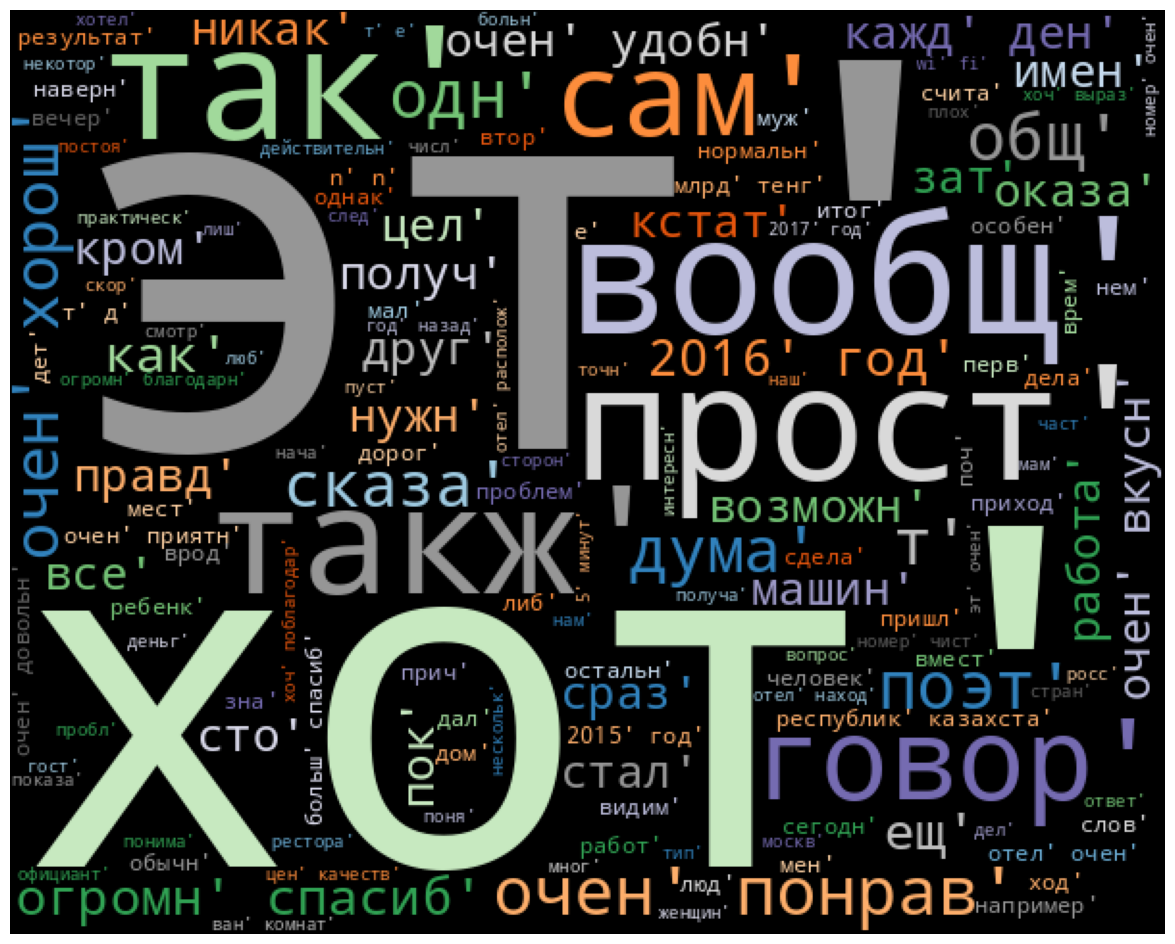

In [748]:
print('Облако слов всего датасета')
generate_basic_wordcloud(text)

Облако слов нейтральный оценок


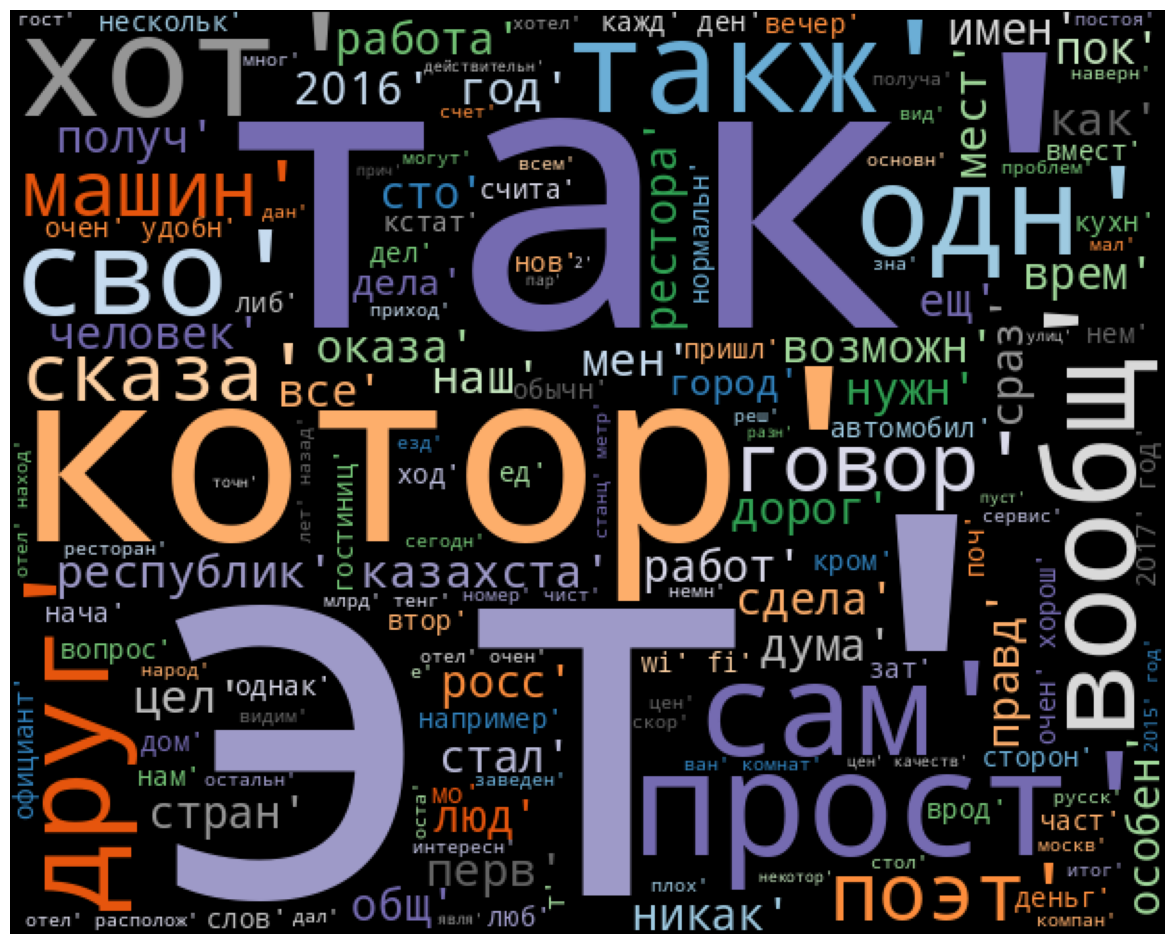

In [749]:
print('Облако слов нейтральный оценок')
generate_basic_wordcloud(text_0)

Облако слов позитивных оценок


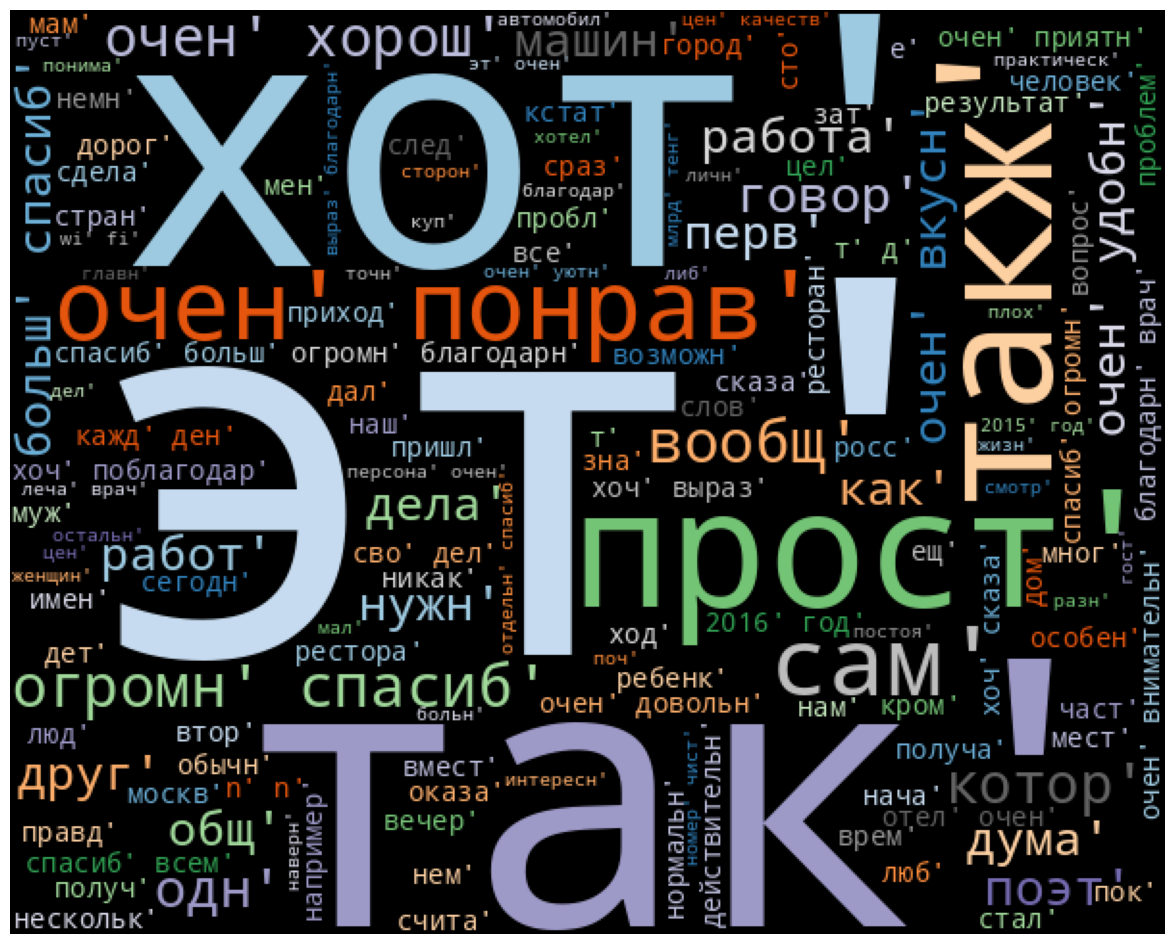

In [750]:
print('Облако слов позитивных оценок')
generate_basic_wordcloud(text_1)

Облако слов негативных оценок


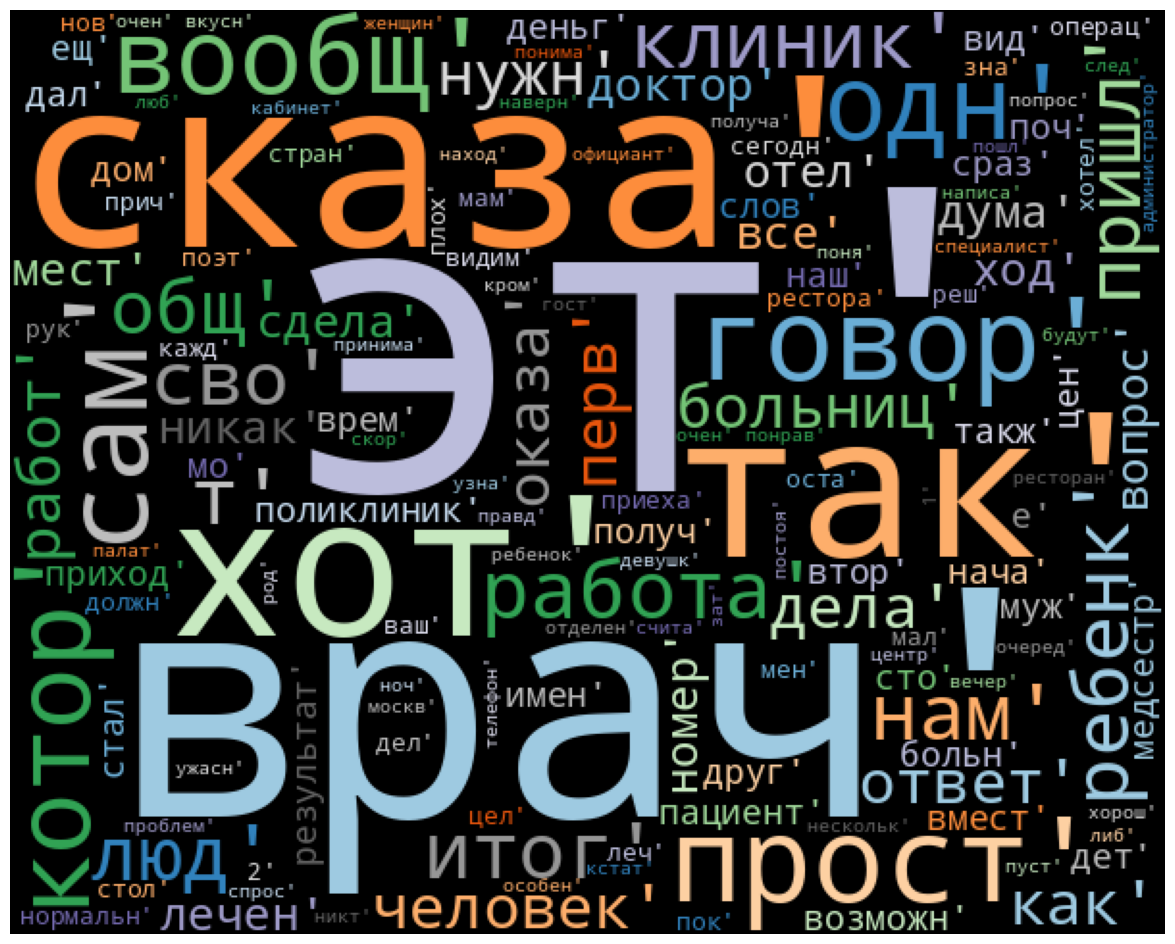

In [751]:
print('Облако слов негативных оценок')
generate_basic_wordcloud(text_2)

Пункт 5 Предложить варианты  дальнейшего улучшения тематического моделирования для имеющегося набора данных 
(перечислить и описать варианты, без реализации)

Можно улучшить lda модель, так как я поставила количество тем 20, то он мне и выделил 20 тем, однако стоило бы провести опыты с моделью с разной тематикой тем, от 2 до того колиечства, который будет показывать наилучшую метрику согласованности (coherence_lda). 

Считаю, что для дальнейшего тематического моделирования, стоит сократить количество тем, так как на карте тем видно, что некоторые темы пересекают друг друга, явно стоит оптимизировать это количество. 

Также в наиболее важных терминах видно что явно остались слова, которые также хотелось бы убрать, напрпимер, "это, наш, нам", а также числа и все союзы.  

А также я убрала бы слова не несущие окраску эмоций, а содержат просто существительные об этом месте: "врач, гостиница, человек". Возможно облака слов и будущие предсказания вообще надо делать только на прилагательных, так как они точнее описывают эмоции. Но это чисто гипотеза моя. С другой стороны в негативных очень часто встречается слово "врач", и либо сам врач вызывает негативные эмоции, либо просто у нас негативные отзывы в основном, связанные с врачами. 

# Часть 2. Обучение классификатора

Пункт 2 Обучить классификатор для определения тональности текста

Пункт 2.1. Разбить данные на train/val/test части: 

Так как по ссылке с HuggingFace уже есть датасеты train и valid, я предположу, что только основной датасет надо сделать тест, а остальное надо загрузить готовое

Пункт 2. 2
Выбрать и обосновать выбор параметров для обучения классификатора

Выбрать и обосновать выбор метрики качества и функции потерь

Обучить модель

Оценить качество классификатора и скорость работы обученной модели на CPU  и  GPU

Я буду обучать классификатор для определения тональности текста с помощью CatBoostClassifier. 
Я выбрала его, потому что у нас задача классификации, а также потому что 
этот метод можно использовать с текстовыми параметрами без дополнительной обработки. 
К тому же, CatBoost прогнозы обычно быстрее других альтернативных, а у мнас очень много данных, и скорость важна. 

Параметры для обучения классификатора - text_features, так как у нас текстовые данные. 

Метрики качества - eval_metric='Accuracy', так как она характеризует качество модели. 

Функция потерь у нас loss_function='MultiClass', так как у нас больше 2х вариантов распределения (0,1,2), то нам надо использовать не бинарный класс, а мульти. 

In [752]:
test = test.drop(['Unnamed: 0'], axis=1)
train = train.drop(['Unnamed: 0'], axis=1)
valid = valid.drop(['Unnamed: 0'], axis=1)

In [753]:
# CatBoost model

In [754]:
# разобъем train на y и X
y_train, X_train = train['sentiment'], train.drop(['sentiment'], axis=1)

In [755]:
# разобъем valid на y и X
y_valid, X_valid = valid['sentiment'], valid.drop(['sentiment'], axis=1)

In [756]:
# создадим классы Pool для CatBoostClassifier
train_pool = Pool(
    data=X_train,
    label=y_train,
    text_features=['text']
)

valid_pool = Pool(
    data=X_valid, 
    label=y_valid,
    text_features=['text']
)

test_pool = Pool(
    data=test[[c for c in test.columns if c!='sentiment']][['text']], 
    label=test['sentiment'],
    text_features=['text']
)

In [757]:
# создадим функцию для обучения модели
def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(
        task_type="CPU",
        loss_function='MultiClass',
        iterations=1000,
        eval_metric='Accuracy',
        od_type='Iter',
        od_wait=100,
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=test_pool,
        verbose=100,
        plot=True,
        use_best_model=True)

P.S. Задание "Оценить качество классификатора и скорость работы обученной модели на CPU и GPU" 
- Делаю только на CPU, так как у меня макбук, и GPU не поддерживается.

In [758]:
# обучим модель
model = fit_model(
    train_pool, valid_pool,
    learning_rate=0.35,
    tokenizers=[
        {
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        }      
    ],
    dictionaries = [
        {
            'dictionary_id': 'Word',
            'max_dictionary_size': '50000'
        }
    ],
    feature_calcers = [
        'BoW:top_tokens_count=10000'
    ]
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5315997	test: 0.5263058	best: 0.5263058 (0)	total: 775ms	remaining: 12m 54s
100:	learn: 0.7088119	test: 0.7043796	best: 0.7043796 (100)	total: 1m 7s	remaining: 9m 56s
200:	learn: 0.7329310	test: 0.7180775	best: 0.7180775 (200)	total: 2m 11s	remaining: 8m 42s
300:	learn: 0.7458121	test: 0.7260404	best: 0.7264196 (295)	total: 3m 12s	remaining: 7m 27s
400:	learn: 0.7566762	test: 0.7336714	best: 0.7340506 (397)	total: 4m 15s	remaining: 6m 22s
500:	learn: 0.7648019	test: 0.7390748	best: 0.7393118 (489)	total: 5m 19s	remaining: 5m 18s
600:	learn: 0.7717585	test: 0.7422978	best: 0.7428666 (593)	total: 6m 21s	remaining: 4m 13s
700:	learn: 0.7782728	test: 0.7443360	best: 0.7443360 (700)	total: 7m 28s	remaining: 3m 11s
800:	learn: 0.7836601	test: 0.7446677	best: 0.7454261 (744)	total: 8m 33s	remaining: 2m 7s
900:	learn: 0.7888210	test: 0.7462793	best: 0.7467058 (820)	total: 9m 36s	remaining: 1m 3s
999:	learn: 0.7927179	test: 0.7500711	best: 0.7503081 (983)	total: 10m 39s	remaining: 0

In [759]:
# bestTest = 0.7503080861
# предскажем на тестовой выборке
y_proba_cb = model.predict_proba(test_pool)
y_pred = np.argmax(y_proba_cb, axis=1)
test['predict'] = model.predict(test_pool)

In [760]:
acc = model.score(test_pool)
print(f"CatBoost model accuracy: {acc}")
# 0.7877282701941808

CatBoost model accuracy: 0.7877282701941808


In [761]:
# дальше построим матрицу правильности предсказания
y_true = test['sentiment'].astype('category').cat.codes.values

In [762]:
target_names = ['Negative', 'Neutral', 'Positive']

<Axes: >

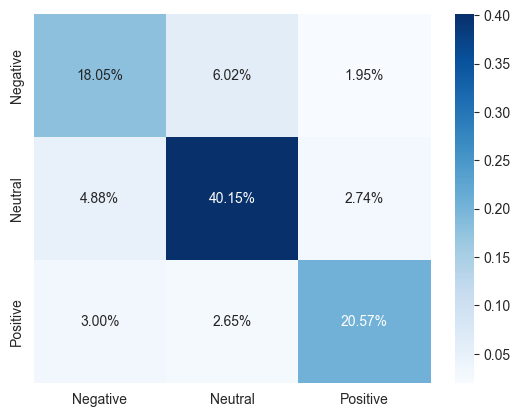

In [763]:
cf_matrix = get_confusion_matrix(model, test_pool)
sns.heatmap(
    cf_matrix/np.sum(cf_matrix),
    annot=True, fmt='.2%', cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names)

In [764]:
print('Classification Report For Catboost')
print(classification_report(
    test['sentiment'].astype('category').cat.codes.values,
    y_pred, target_names=target_names))

Classification Report For Catboost
              precision    recall  f1-score   support

    Negative       0.70      0.69      0.70     54887
     Neutral       0.82      0.84      0.83    100792
    Positive       0.81      0.78      0.80     55310

    accuracy                           0.79    210989
   macro avg       0.78      0.77      0.78    210989
weighted avg       0.79      0.79      0.79    210989



В общем и целом, выглядит так, что наша модель справляется с предсказаниями тональности текстов. Confusion matrix показывает хорошие результаты, а accuaracy достаточно высокое - 0.78. 

Пункт 3 Предложить варианты для дальнейшего улучшения качества и скорости работы модели (перечислить и описать варианты, без реализации).

Первое, что стоит сделать, предобработать данные, как мы это делали в 1 части задания, то есть следует убрать лишнее, стоплова, привести слова к стемминг-форме, и убрать нечасто встречающиеся слова, которые явно не влияют на обучение, также можно изменить количество итераций. Можно изменить learning_rate: увеличить его, так как нет переобучения, и accuracy еще явно не достигла максимума. 